In [1]:
%pip install -q networkx neo4j matplotlib

Note: you may need to restart the kernel to use updated packages.


# Import Extracted Relations

Import directly from dumped pickle files.

In [2]:
import networkx as nx
import pickle

# Load relations
with open('./output/relations/chunk-level-relations.pickle', 'rb') as file:
    cl_relations = pickle.load(file)

# Load entity type mapping    
with open('./output/relations/relations-entity-type.pickle', 'rb') as file:
    entity_types_mapping = pickle.load(file)

# Initialize Knowledge Graph
KG = nx.DiGraph()

# Add relations to KG
for relation in cl_relations:
    
    # discard relations with missing values
    try:
        KG.add_edge(relation[0], relation[1], relation=relation[2], relation_type=relation[3])
    except IndexError as e:
        print(f'ImportRelationsError: item: {relation} => error: {e}')

# Add entity types to KG
for node in KG.nodes():
    KG.nodes[node]['type'] = entity_types_mapping.get(node, 'Miscellaneous')

Create a toy node type selector and visualize the knowledge graph.

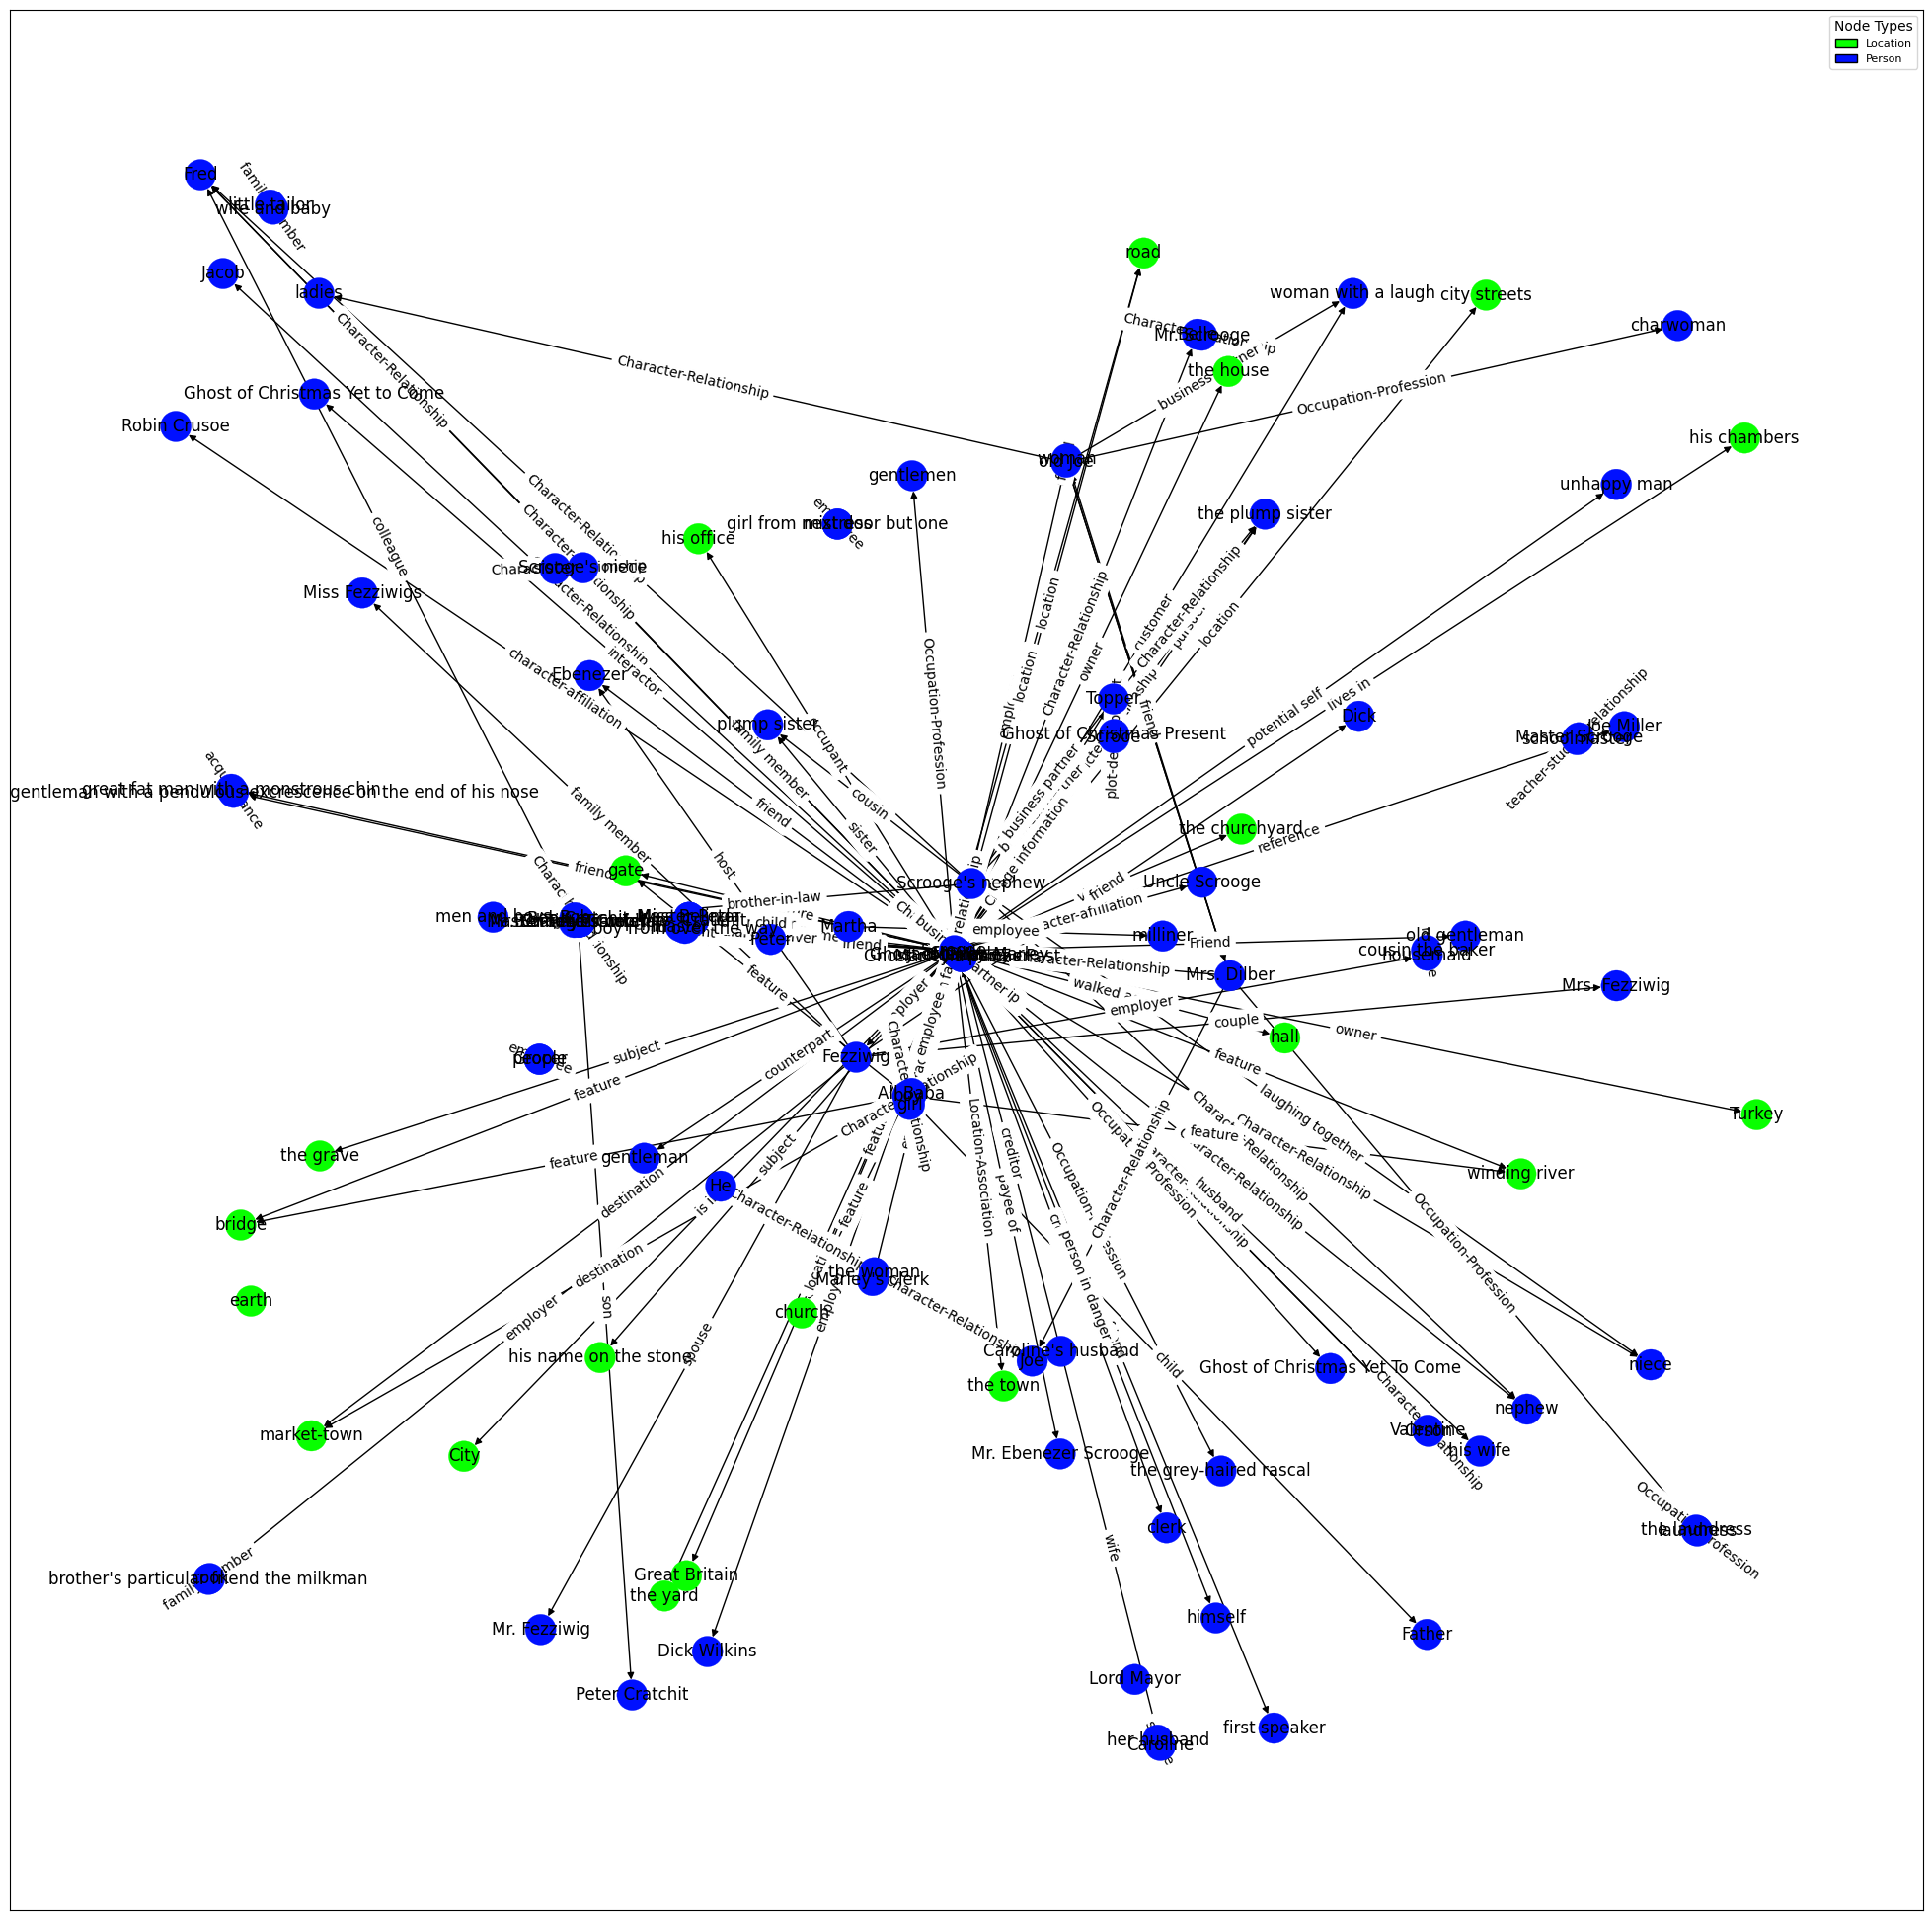

(<Figure size 2500x2500 with 1 Axes>, <Axes: >)

In [3]:
from utils.nx_util import draw_kg

def subgraph_by_entity_type(G, node_type):
    """
    Extract subgraph by node type
    """
    
    # if node_type is not a list
    if not isinstance(node_type, list):
        node_type = [node_type]
        
    nodes_of_type_X = [node for node, attr in G.nodes(data=True) if attr.get("type") in node_type]
    
    subgraph = G.subgraph(nodes_of_type_X)
    
    return subgraph

all_types = list(set(entity_types_mapping.values()))

# create the subgraph by choosing ['Person', 'Location']
sub = subgraph_by_entity_type(KG, ['Person', "Location"])

draw_kg(sub,
        k=1e-8,
        figsize=(25, 25),
        node_size=500,
        file_name='./output/pics/subgraph_example.png', 
        font_size=5,
        )

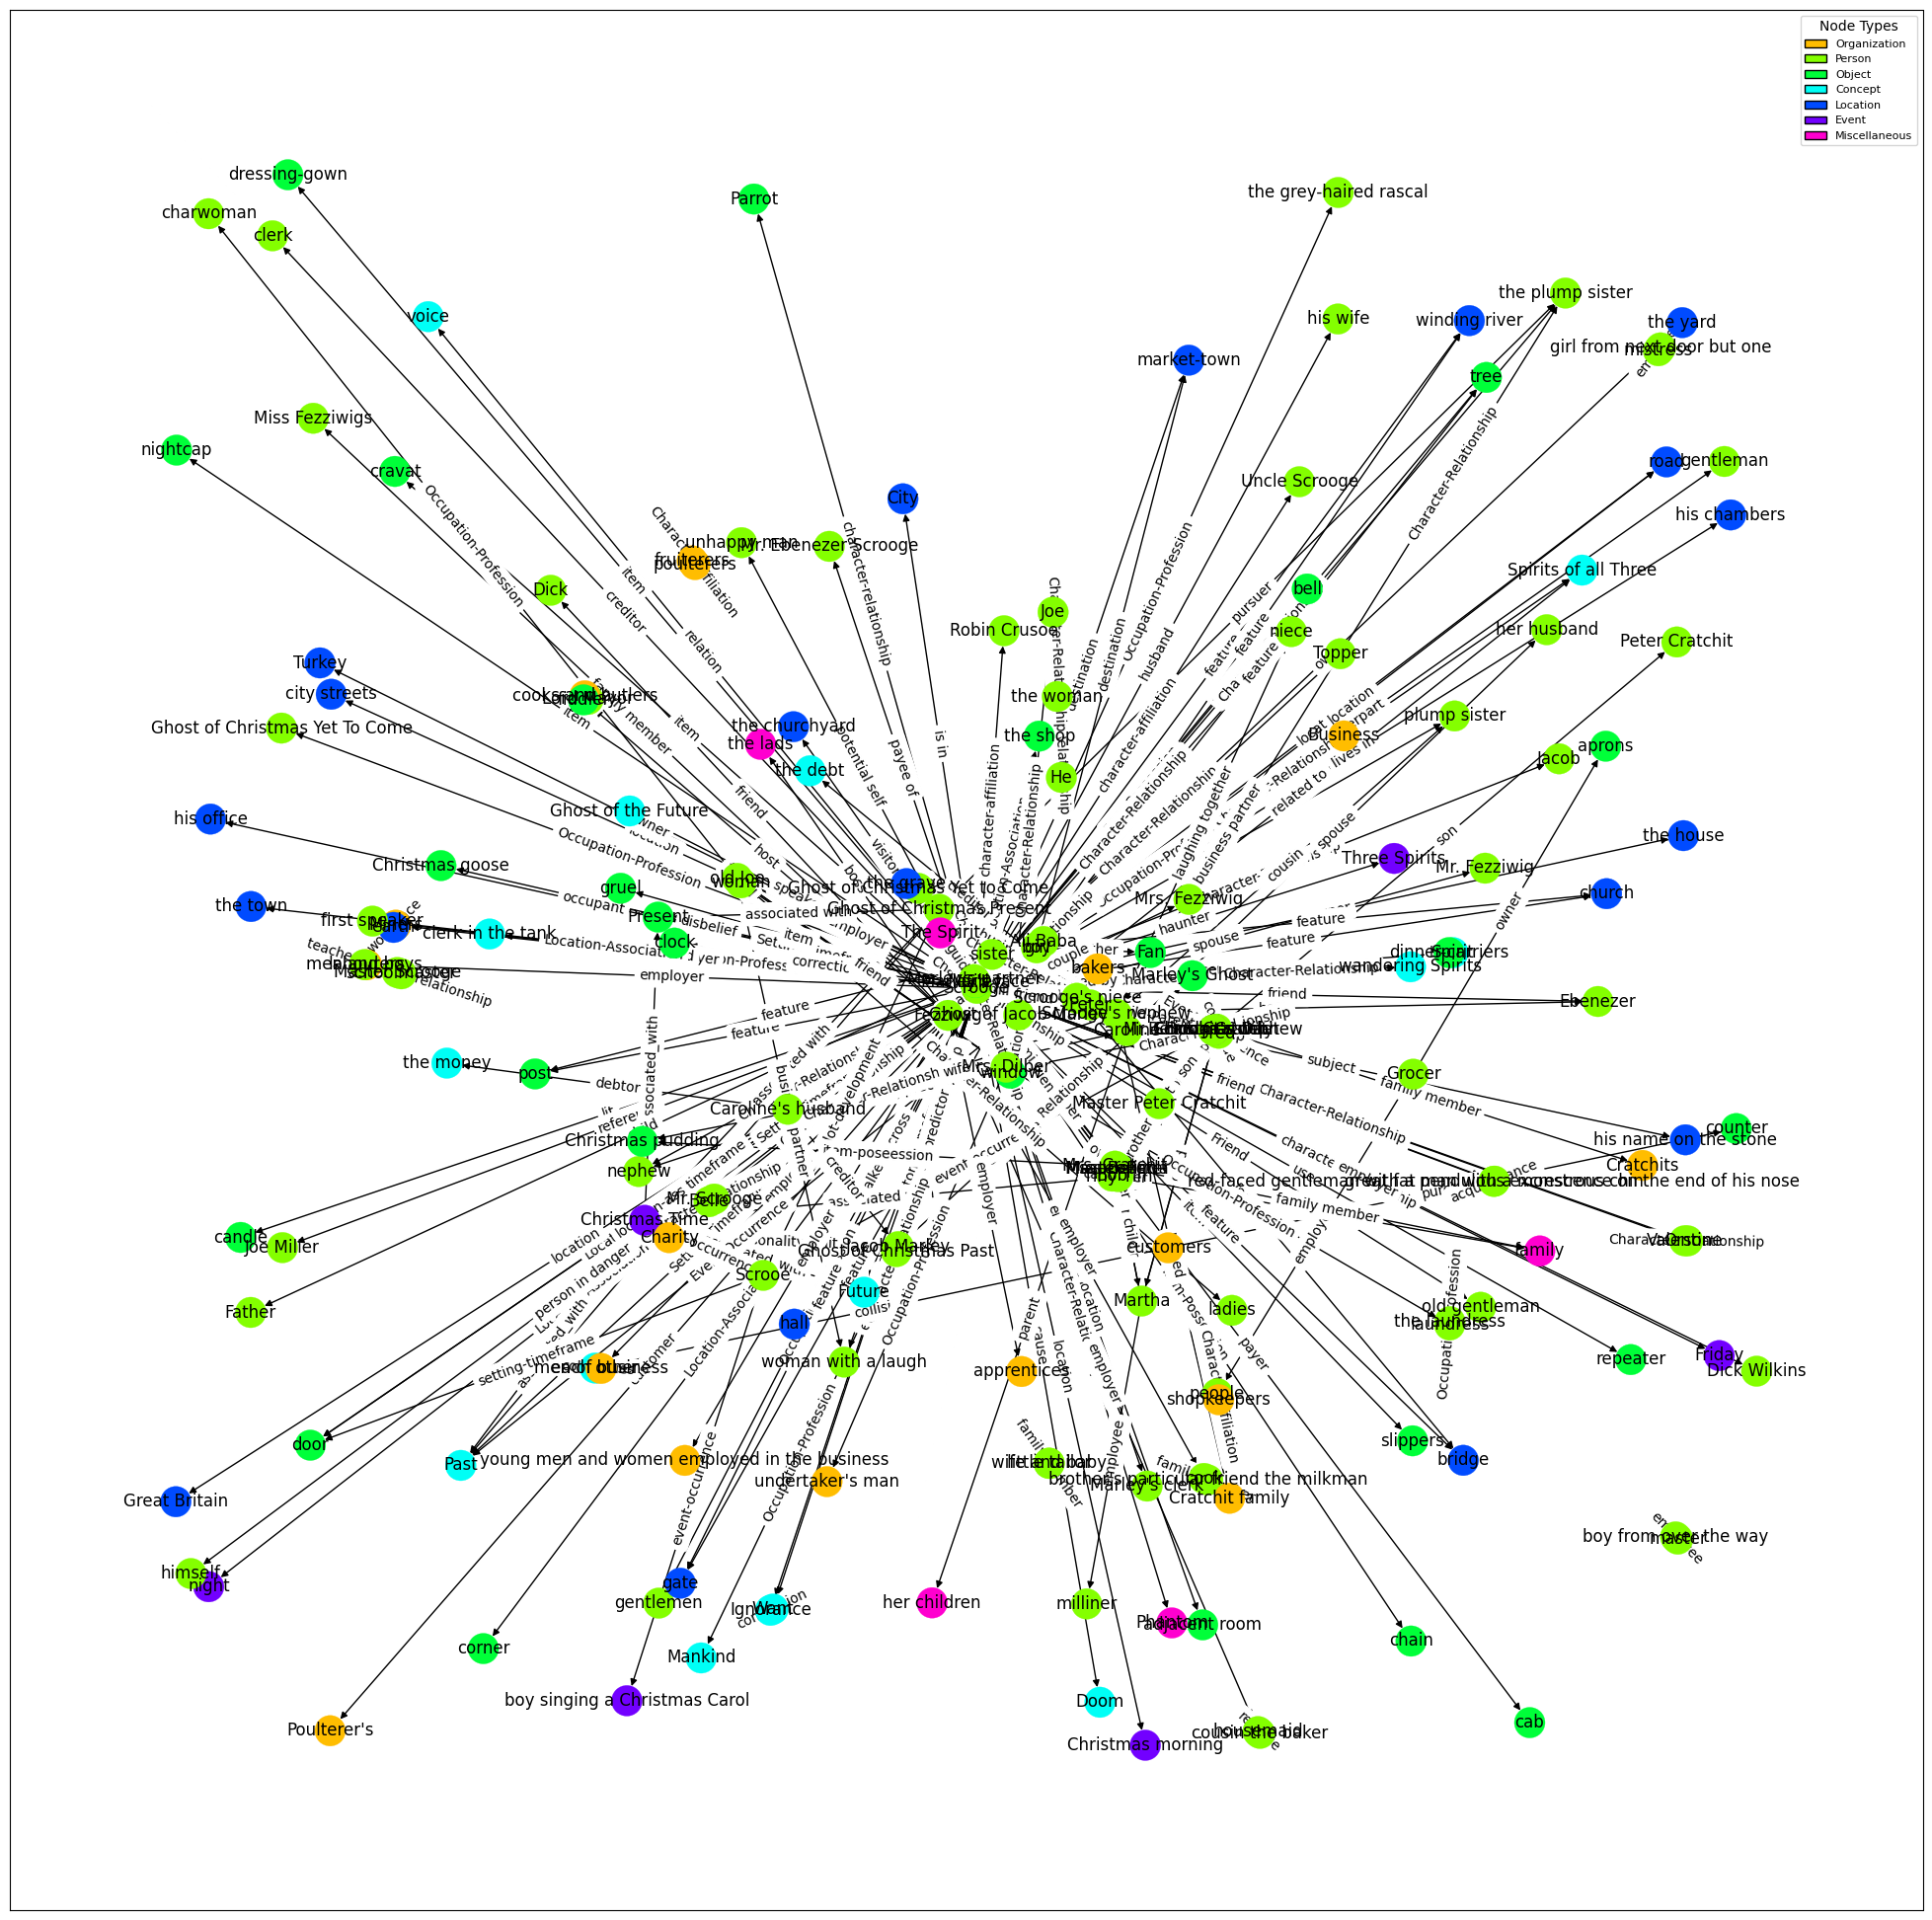

(<Figure size 2500x2500 with 1 Axes>, <Axes: >)

In [4]:
# A simple visualization of the whole KG

draw_kg(KG,
        k=1e-9,
        figsize=(25, 25),
        node_size=500,
        file_name='./output/pics/kg-networkx-example.png', 
        font_size=5,
        )

# Export to GraphML

In [5]:
nx.write_graphml(KG, './output/KGs/kg.graphml')

# Export to Neo4j

For safety, if you have a cloud Neo4j instance running, you can download the credentials from the cloud console and save them in a `.env` file.

In [6]:
from dotenv import dotenv_values

# use .env credentials
dotenv_values(".env")

# local connection
URI = "neo4j://localhost"
USER = "neo4j"
PASSWORD = "neo4jneo4j"


# This is our import helper class
from utils.neo4j_util import Neo4jGraphImporter

neo4j_importer = Neo4jGraphImporter(
        uri=URI, 
        user=USER, 
        password=PASSWORD
    )

neo4j_importer.clear_database()  # Optional: Clear the database
neo4j_importer.drop_all_constraints() # Optional: Drop all constraints

neo4j_importer.import_graph(KG)

Database cleared.
All constraints dropped.
